In [2]:
# inspired from: A deep understanding of deep learning

# Data information:
# https://archive.ics.uci.edu/ml/datasets/Heart+Disease

# Data source
# https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data



import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

from sklearn.model_selection import train_test_split

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')


# %matplotlib widget
%matplotlib notebook
%matplotlib inline


In [3]:
url  = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
data = pd.read_csv(url,sep=',',header=None)
data.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','DISEASE']


data = data.replace('?',np.nan).dropna()

data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,DISEASE
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3


In [4]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,DISEASE
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.946128
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,1.234551
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


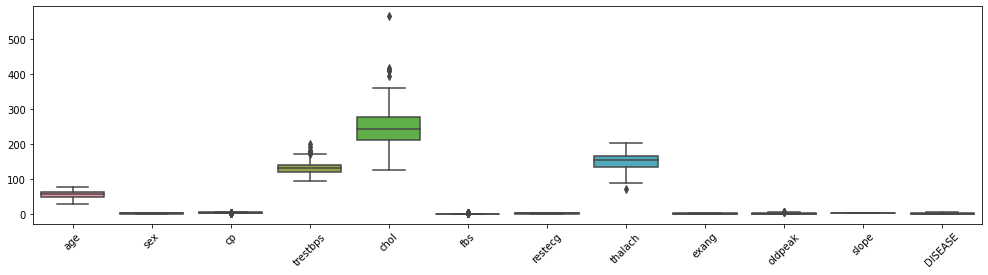

In [5]:
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [6]:
# z-score the non-categorical columns
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop(['sex','fbs','exang','DISEASE'])
cols2zscore

for c in cols2zscore:
  d = pd.to_numeric(data[c]) # force to numeric (addresses some data-format issues)
  data[c] = (d - d.mean())/d.std(ddof=1)

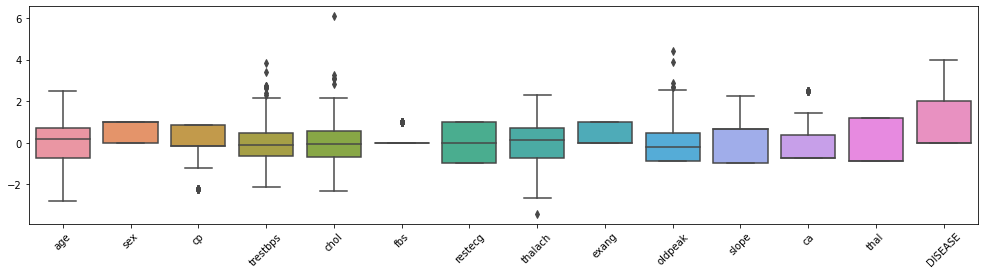

In [7]:
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [8]:
data['DISEASE'].value_counts()

0    160
1     54
2     35
3     35
4     13
Name: DISEASE, dtype: int64

In [9]:
# re-code events to 0 (absent) and 1 (present)

data['DISEASE'][data['DISEASE']>0] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
dataT  = torch.tensor( data[data.keys().drop('DISEASE')].values ).float()
labels = torch.tensor( data['DISEASE'].values ).float()

print( dataT.shape )
print( labels.shape )

labels = labels[:,None]
print( labels.shape )

torch.Size([297, 13])
torch.Size([297])
torch.Size([297, 1])


In [11]:
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=50)

train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

batchsize    = 20
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [12]:
for X,y in train_loader:
  print(X.shape,  y.shape)

torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])


In [13]:
class theNet(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(13,32)
    
    ### hidden layers
    self.fc1 = nn.Linear(32,64)
    self.fc2 = nn.Linear(64,10)

    ### output layer
    self.output = nn.Linear(10,1)


  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x)



In [14]:
net = theNet()

X,y = next(iter(train_loader))
yHat = net(X)
print(yHat)

lossfun = nn.BCEWithLogitsLoss()
lossfun(yHat,y)

tensor([[0.2678],
        [0.2318],
        [0.2180],
        [0.2813],
        [0.2535],
        [0.2480],
        [0.2663],
        [0.2436],
        [0.2279],
        [0.2965],
        [0.2430],
        [0.2889],
        [0.2375],
        [0.2327],
        [0.2222],
        [0.2683],
        [0.2109],
        [0.2907],
        [0.2591],
        [0.2838]], grad_fn=<AddmmBackward0>)


tensor(0.7180, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [15]:
# start with a fresh network
net = theNet()
optimizer = torch.optim.Adam(net.parameters(),lr=.0001)
lossfun = nn.BCEWithLogitsLoss() # try with different loss function


# number of training epochs
numepochs = 100


trainLoss = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)
trainAcc  = torch.zeros(numepochs)
testAcc   = torch.zeros(numepochs)


for epochi in range(numepochs):

  batchLoss = []
  for X,y in train_loader:

    yHat = net(X)
    loss = lossfun(yHat,y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    batchLoss.append(loss.item())
    
    predictions = (torch.sigmoid(yHat)>.5).float()
    trainAcc[epochi] = 100*torch.mean((predictions==y).float())



  trainLoss[epochi] = np.mean(batchLoss)



  X,y = next(iter(test_loader))
  yHat = net(X)
  
  loss = lossfun(yHat,y)
  testLoss[epochi] = loss.item()
  
  predictions = (torch.sigmoid(yHat)>.5).float()
  testAcc[epochi] = 100*torch.mean((predictions==y).float())
  

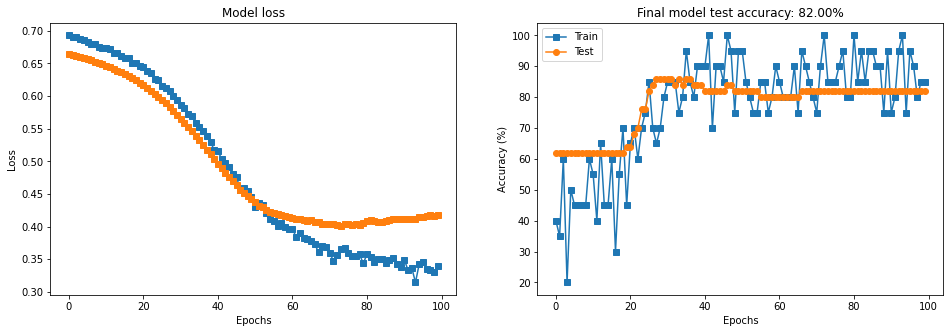

In [16]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'s-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()